**DO NOT EDIT THIS FILE WITHIN THE /TSDS FOLDER - YOU RISK OVERWRITING YOUR WORK THE NEXT TIME YOU PULL FROM THE GITHUB REPOSITORY**

# Assignment 3


### Practical info
* Handin in absalon. The deadline is the 23rd of April (see the [course plan](https://github.com/abjer/tsds/wiki/Course-plan))
* You must work in groups of 2-4. **Remember to identify the group members in the filename or in the top of the file contents**.
* If anything is unclear dont hesitate to email me at kuol@econ.ku.dk with questions.

<br>

<br>
<br>
<br>
<br>

# Questions from exercise set 9 (Spatial #1)


In [1]:
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns

import folium
import geopandas as gpd
import fiona
import shapely

%matplotlib inline

{'init': 'epsg:4326'}


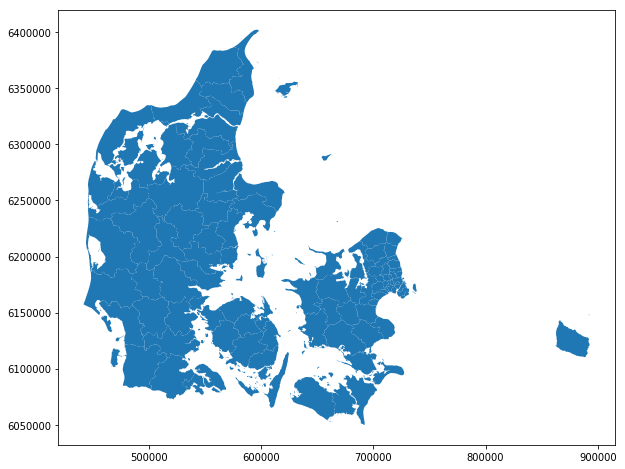

In [2]:
# Run this code to get set up for exercise 9.2.2 - 9.2.5

url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"
kommuner = gpd.read_file(url)
print(kommuner.crs)
kommuner.to_crs({'init': 'epsg:25832'},inplace=True)
kommuner.plot(figsize=(14,8))

kommuner.columns = kommuner.columns.str.lower()
    
# information for municipality
kommune_info = pd.read_json('https://dawa.aws.dk/kommuner')\
                .pipe(lambda df: \
                        df.assign(komkode=df.kode.astype(str).str.zfill(4)))\
                .loc[:,['komkode','regionskode']]\
                

region_info = pd.read_json('https://dawa.aws.dk/regioner/')\
                .loc[:,['kode','navn']]\
                .add_prefix('regions')

kommuner = kommuner\
                .merge(kommune_info,how='left')\
                .merge(region_info,how='left')


dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}
def cell_coords_to_polygons(square_df, x='e', y='n', dist=500, crs=dk_crs):
    '''
    Convert coordinates to squares in a GeoDataFrame.
       
    Parameters
    ----------
    x : str
        Name of the horizontal coordinate (~longitude)            
    y : str
        Name of the vertical coordinate (~latitude)                        
    dist : int or float
        Size of polygons
    crs : dict
        Coordinate Reference System


    Returns
    ----------
    squares_gdf: geopandas.GeoDataFrame
        This table contains squares as geometry
        and the original data.
    '''
    
    def _to_square_polygon(row):
        '''
        This auxiliary function convert a square's lower,left 
        coordinates to a polygon. 
        
        Parameters
        ----------
        row : pandas.Series
            This is a DataFrame row.            
        
        Returns
        ----------
        poly: shapely.Polygon        
        
        '''
        
        square_coords = ((row[x], row[y]), 
                         (row[x]+dist, row[y]), 
                         (row[x]+dist, row[y]+dist), 
                         (row[x], row[y]+dist))
        
        poly = shapely.geometry.Polygon(square_coords)
        
        return poly
    
    # convert to polygons
    square_geoms = gpd.GeoSeries(square_df.apply(_to_square_polygon, axis=1), crs=crs)
    
    # make GeoDataFrame
    square_gdf = gpd.GeoDataFrame(data=square_df, geometry=square_geoms)
    
    return square_gdf

**Ex. 9.2.2** Make two boolean series as follows. 
 - first: row is True if corresponding the row shape is in the Capital Region or Sealand Region (i.e. `'Region Hovedstaden', 'Region Sjælland'`) 
 - second: row is True if the  the row geometry is ***not*** in Bornholm or nearby (i.e. `'Bornholm', 'Christiansø'`)

Finally make a combined series which takes the value True if both holds, otherwise False and use this series to select rows in the GeoDataFrame. 

> *Hint*: recall that we can check if a series elements are elements in a series using the `isin` method


In [3]:
# [Answer to ex. 9.2.2 here]
kommuner["first"]=kommuner["regionsnavn"].isin(['Region Hovedstaden', 'Region Sjælland'])

kommuner["second"]=~kommuner["regionsnavn"].isin(['Bornholm', 'Christiansø'])

**Ex. 9.2.3** Explain what is the CRS of the GeoDataFrame. How is distance measured using this coordinate system. Extract the extremum values (min,max) in all dimensions.

> *Hint*: extreme values, i.e. bounds, can be found using `.bounds` on a GeoDataFrame (also works on shapes, GeoSeries)

In [5]:
# [Answer to ex. 9.2.3 here]
# CRS are important because they tell Python how to interpret the coordinates in a GeoSeries.
# There different projections with which coordinates can be related to locations on earth.
# In general, all projections of locations on the Earth into a two-dimensional plane are distortions. 
# We chose a projection that is best for our application to our large-scale map.
# It employs UTM. 

# The distance is measured in metres: https://epsg.io/25832

print('min coordinates: \n', 'x:', kommuner.total_bounds[0], 'y:', kommuner.total_bounds[1], '\n\n', \
      'max coordinates: \n', 'x:', kommuner.total_bounds[2], 'y:', kommuner.total_bounds[3])

min coordinates: 
 x: 441675.99999999994 y: 6049781.999990508 

 max coordinates: 
 x: 892786.9996185575 y: 6402216.999996983


#### Interpolation of house prices


In the following two exercises we aim to compute local spatial neighborhood measures of house prices in Sealand and around. We do this by making make a grid of Sealand houseprice data. Thus the exercise will illustrate how to make a interpolation of data which is useful for feature engineering and get a good understanding of the data.

**Ex. 9.2.4** We are now to construct a 500mx500m grid for Sealand:
- Make a grid of points 500m apart in horizontal and vertical directions that are within the extremum values of Sealand's shape. 
- For each of these points construct a square polygon assuming that the point is the south west corner of the square. 
- Select all the house sales that take place within the Sealand and nearby islands.

> *Hint 1:* Once you have created the grid the following function below may be useful for converting into a GeoDataFrame. You need to specify the column names for your x and y coordinates.

> *Hint 2:* We can select the points that intersect by using a spatial join between the house locations and municipalities.

In [6]:
# [Answer to ex. 9.2.4 here]

# DK as one shape
denmark_shape = kommuner.unary_union

# Capital region (without Bornholm) as one shape
cap_reg = kommuner.regionsnavn.isin(['Region Hovedstaden'])
non_bornholm = kommuner.bounds.minx<800000

kommuner_select = kommuner[cap_reg & non_bornholm]
cap_region = kommuner_select.unary_union

# Capital region (without Bornholm) as one shape
sealand_reg = kommuner.regionsnavn.isin(['Region Hovedstaden', 'Region Sjælland'])
non_bornholm = ~ kommuner.komnavn.isin(['Bornholm', 'Christiansø'])

kommuner_select_sealand = kommuner[sealand_reg & non_bornholm]
sealand_shape = kommuner_select_sealand.unary_union

**Ex. 9.2.5** Compute interpolation of house price for each grid cell as follows:
- Load the pre-structured data with house sales prices for the capital region of Denmark
- Make a loop over sale_year
    - Fit a nearest neighbor regression model to the square meter price (i.e. `price_area` for each year)
        - Set number of neighbors to 25 and radius to 25000
    - Apply the model to the grid data and assign as a column
- Plot the grid data for 2012

In [7]:
# [Answer to ex. 9.2.5 here]

from sklearn.neighbors import KNeighborsRegressor

price_gdf = gpd.read_file('house_prices.geojson')
price_gdf['n'] = price_gdf.geometry.y
price_gdf['e'] = price_gdf.geometry.x

knr = KNeighborsRegressor(n_neighbors=25, radius=25000)

price_coord = price_gdf[(price_gdf.sale_year==2015)].dropna(subset=['sale_year', 'e', 'n', 'price_area'])

price_nn = knr.fit(X=price_coord[['e', 'n']].values, y=price_coord.price_area.values)

square_gdf_s['p'+str(2015)] = np.log10(price_nn.predict(square_gdf_s[['e', 'n']] + 250))

square_gdf_s.plot(column='p2012', figsize=(6,9))

DriverError: house_prices.geojson: No such file or directory

<br>
<br>
<br>
<br>

# Questions from exercise set 10 (Spatial #2)

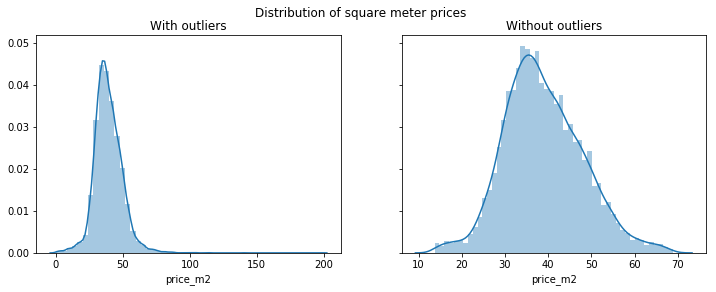

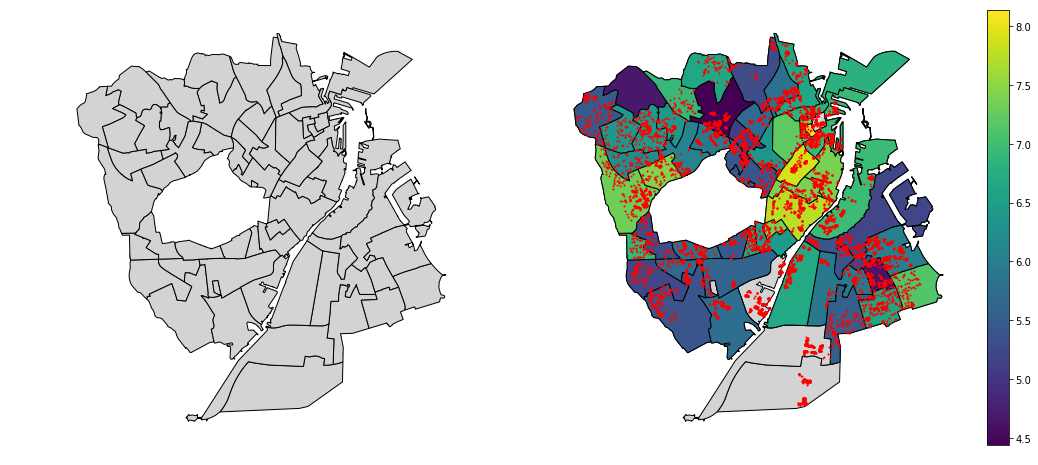

In [72]:
import shapely as shp
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.formula.api as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# You need to download these files to get going. See the exercise set 
# for instructions.
districts = gpd.read_file('data/school_districts_2017_2018.geojson')
socioeco = gpd.read_file('data/socioeco_edited.geojson')
school_perf = pd.read_csv('data/school_perf.csv')
house_sales = gpd.read_file('data/sales.geojson')

cph_map = gpd.read_file('data/cph_map.geojson').iloc[0,0]

districts = districts[['skoleid','skolenavn','geometry']]
house_sales = house_sales[house_sales['year']>2016]

percs = house_sales['price_m2'].quantile([0.01,0.99])

sales_dist_plt = plt.subplots(1,2,sharey=True,figsize=(12,4))
sns.distplot(house_sales['price_m2'], ax=sales_dist_plt[1][0]) 
house_sales = house_sales[(percs[0.01]<house_sales['price_m2']) & (house_sales['price_m2']<percs[0.99])]
sns.distplot(house_sales['price_m2'], ax=sales_dist_plt[1][1])
sales_dist_plt[1][0].set_title('With outliers')
sales_dist_plt[1][1].set_title('Without outliers')
sales_dist_plt[0].suptitle('Distribution of square meter prices')
plt.show()

districts_perf = districts.merge(school_perf[school_perf['year']<2017].drop('year',axis=1).groupby('skolenavn',as_index=False).mean())

socioeco_sub = socioeco\
    .loc[socioeco['aar']==2016,['rode_nr','geometry']]\
    .merge(socioeco[socioeco['aar']>2012]\
               .groupby('rode_nr',as_index=False)\
               .mean()
          )\
    .drop('aar',axis=1)


districts_perf_plt = plt.subplots(1,2,figsize=(18,8), gridspec_kw = {'width_ratios':[1,1.25]})
districts.plot(color='lightgrey',edgecolor='black',ax=districts_perf_plt[1][0])
districts.plot(color='lightgrey',edgecolor='black',ax=districts_perf_plt[1][1])
districts_perf.plot(edgecolor='black',column='karsnit',legend=True,ax=districts_perf_plt[1][1])
house_sales.plot(color='red', markersize=1,ax=districts_perf_plt[1][1])
districts_perf_plt[1][0].set_axis_off()
districts_perf_plt[1][1].set_axis_off()
plt.show()

**Ex 10.1.1**: *Border regions between school districts*.
 Make a function that finds the borders between the school districts given some specified border-width W. Make sure that your border building function satisfy the following constraints:
 - The borders should not intersect each other. There should be no borders between the school districts without any grade data and any other school districts. 
 - Do not include borders between two school districts, if the district border coincides with a natural geographical border, such that the neighborhoods on each side of the geographical border are likely to be systematically different with regard to other variables than the school characteristics. For instance, it would be natural to exclude the Christianhavn school district from the analysis, since it is surrounded by the harbor and *Voldene*, and likewise it would be natural not to include the border between two school districts, if they are on different sides of the harbor. 

 Compute the borders for the following border meter widths: 50, 100, 200, 300, 500. A border width of, for instance, 50 meters means that the computed border area should reach 25 meter into each district along the actual border:

> **Hint**: One approach is to use a combination of the *buffer* and *overlay* function from *Geopandas* to construct the borders. Depending on your choice of method, the found borders will likely overlap, but you can then use *overlay* to find the overlap. After you have found the overlaps, you can use the *shapely* function *difference* to remove them. You can use a similar approach with the *cph_map* from above to remove borders between school districts on different sides of the harbor.

> **Hint 2**: The borders produced should look like this.

<img src="https://github.com/abjer/tsds/raw/master/material/10_spatial2/border_plt.png">


In [73]:
# [Answer to ex. 10.1.1 here]


# The school districts with no data 
schools = school_perf['skolenavn'].unique()
no_perf_area = districts[~(districts['skolenavn'].isin(schools))]['geometry'].unary_union

def make_borders(districts, border_width) :

    

    ################

    # make borders #

    ################

    

    # put buffer 

    buffer_dist = border_width / 2

    districts['geometry'] = districts.buffer(buffer_dist)

    

    # make overlay

    borders = gpd.overlay(districts,districts,how='intersection')

    borders = borders[~(borders['geometry'].apply(lambda poly : poly.is_empty))]

    borders = borders[borders['skoleid_1']!=borders['skoleid_2']]

    

    # name borders

    borders['border_id'] = borders.apply(lambda row : sorted((row['skoleid_1'],row['skoleid_2'])),axis=1)

    borders['border_id'] = borders['border_id'].apply(lambda border : '{0}-{1}'.format(border[0],border[1]))

    borders = borders.drop_duplicates('border_id').reset_index(drop=True)

    

    #####################

    # remove irrelevant #

    #####################

    

    # conflicting border 

    conflict_b = gpd.overlay(borders[['border_id','geometry']],

                             borders[['border_id','geometry']],

                             how='intersection')

    non_empty = pd.Series(~(conflict_b['geometry'].apply(lambda poly : poly.is_empty)))

    has_conflict = conflict_b['border_id_1']!=conflict_b['border_id_2']      

    conflict_b_uu = conflict_b[non_empty & has_conflict].geometry.unary_union

        

    # join with water 

    removal = shp.geometry.box(*cph_map.bounds).difference(cph_map).buffer(buffer_dist)    

    removal = removal.union(conflict_b_uu).union(no_perf_area.buffer(buffer_dist))

    

    # apply removal 

    borders['geometry'] = borders['geometry'].apply(lambda border : border.difference(removal))

    borders = borders[~(borders['geometry'].apply(lambda poly : poly.is_empty))]

    

    return borders.reset_index(drop=True)

# Apply function
border_widths = [50,100,150,200,300,500]
remove_chr_havn = districts_perf['skolenavn']!='Christianshavns Skole'
# removal, conflict_b_uu, no_perf_area, buffer_dist = make_borders(districts_perf[remove_chr_havn].copy(),50)
borders = [make_borders(districts_perf[remove_chr_havn].copy(),d) for d in border_widths]

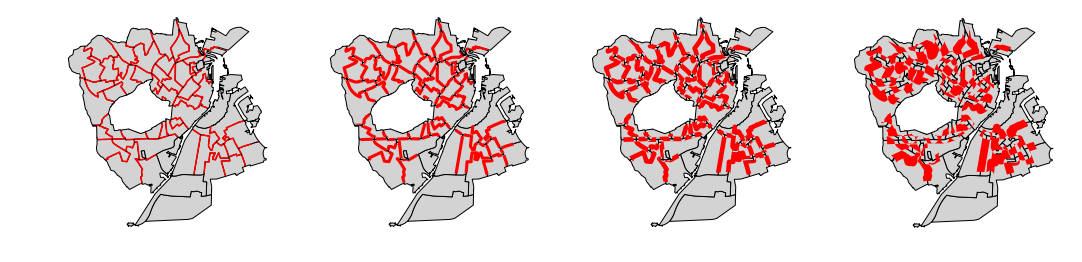

In [74]:


districts_perf_plt = plt.subplots(1,4,figsize=(18,8))
districts.plot(color='lightgrey',edgecolor='black',ax=districts_perf_plt[1][0])
districts.plot(color='lightgrey',edgecolor='black',ax=districts_perf_plt[1][1])
districts.plot(color='lightgrey',edgecolor='black',ax=districts_perf_plt[1][2])
districts.plot(color='lightgrey',edgecolor='black',ax=districts_perf_plt[1][3])
borders[1].plot(color='red',ax=districts_perf_plt[1][0])
borders[3].plot(color='red',ax=districts_perf_plt[1][1])
borders[4].plot(color='red',ax=districts_perf_plt[1][2])
borders[5].plot(color='red',ax=districts_perf_plt[1][3])
districts_perf_plt[1][0].set_axis_off()
districts_perf_plt[1][1].set_axis_off()
districts_perf_plt[1][2].set_axis_off()
districts_perf_plt[1][3].set_axis_off()

**Ex 10.1.2**: Do the following
  1. Merge the residential sales with the school districts and socioeconomic data based on the coordinates of the sale and the school districts and rode areas (CPH municapality's spatial cells). 
  2. Find the residential sales located within the sets of borders for the different border widths. 
  3. Plot the located within the border sets for the different border widths.

> **Hint**: Recall the `sjoin` function from `geopandas` may be of help.

The selected houses within borders should look like:

<img src="https://github.com/abjer/tsds/raw/master/material/10_spatial2/border_sales_plt.png">


In [75]:
house_sales_dp=gpd.sjoin(left_df = house_sales, right_df = districts_perf, how = 'left', op = 'within').drop('index_right',axis=1)
house_sales_char = gpd. sjoin(left_df = house_sales_dp, right_df = socioeco_sub, how ='left', op='within').drop('index_right',axis=1)
border_sales=[gpd.sjoin(left_df=house_sales_char, right_df=bord[['border_id','geometry']],how='inner',op='within').drop('index_right',axis=1)for bord in borders]


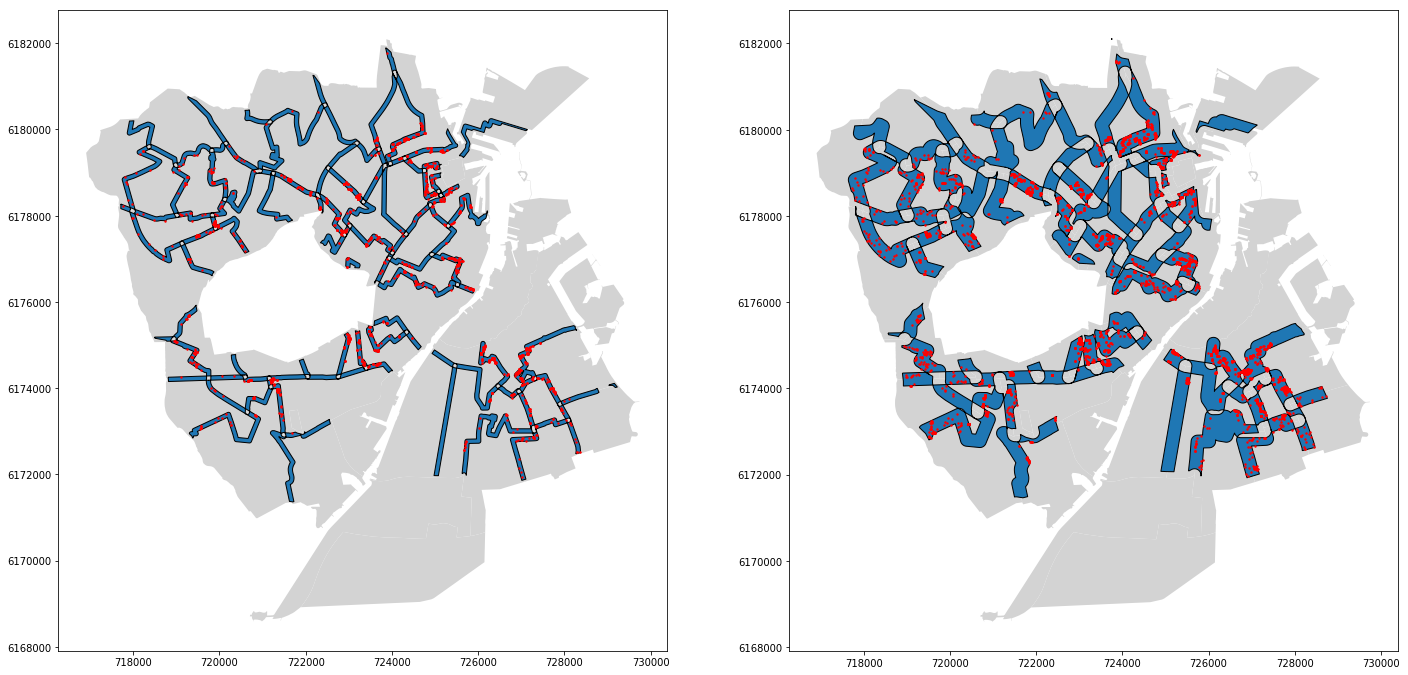

In [76]:

border_sales_plt=plt.subplots(1,2,figsize=(24,12))
districts.plot(color='lightgrey',ax=border_sales_plt[1][0])
borders[1].plot(edgecolor='black',ax=border_sales_plt[1][0])
border_sales[1].plot(color='red',markersize=2,ax=border_sales_plt[1][0])
districts.plot(color='lightgrey',ax=border_sales_plt[1][1])
borders[4].plot(edgecolor='black',ax=border_sales_plt[1][1])
border_sales[4].plot(color='red',markersize=2,ax=border_sales_plt[1][1])

<br>

**Ex 10.1.3**:  Run a linear regression of the effect of schools' grade average on square meter prices, where you control for the size of the sold property and relevant socioeconomic properties of the neighborhood. We have used percent of non-western immigrants and descendants, low income, non-educated and high school educated as our socioeconomic variables, but you can play around with it.

In [77]:

hs=house_sales_char

import statsmodels.formula.api as smf
results_1 = smf.ols('price_m2~karsnit + res_area  ', data=hs).fit()
print()
print()
print('I dont speak Danish so I have no idea which variables are tge social economic properties mentioned above')
print('So I didn\'t add any control varibles in my regression')
print()
print()
print(results_1.summary())



I dont speak Danish so I have no idea which variables are tge social economic properties mentioned above
So I didn't add any control varibles in my regression


                            OLS Regression Results                            
Dep. Variable:               price_m2   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     653.5
Date:                Fri, 19 Apr 2019   Prob (F-statistic):          9.24e-267
Time:                        15:12:49   Log-Likelihood:                -34201.
No. Observations:                9563   AIC:                         6.841e+04
Df Residuals:                    9560   BIC:                         6.843e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t    

<br>

**Ex 10.1.4**:  For each border width now try to run a linear regression of the effect of schools' average grade on square meter prices, where you only use the sales within the borders and control for residential area, socioeconomic neighborhood properties and border fixed effects.

In [78]:
import statsmodels.formula.api as smf

print()
print()
print('I dont speak Danish so I have no idea which variables are tge social economic properties mentioned above')
print('So I didn\'t add any control varibles in my regression')
print()
print()

results = []

for i in range(len(border_sales)):
    bs= border_sales[i]
    results = results + [smf.ols('price_m2~karsnit + res_area +border_id', data=bs).fit()]
    print()
    print('The result for border width', border_widths[i] ,'is ')
    print()
    print(results[i].summary())
    print()
    print()
    print()



I dont speak Danish so I have no idea which variables are tge social economic properties mentioned above
So I didn't add any control varibles in my regression



The result for border width 50 is 

                            OLS Regression Results                            
Dep. Variable:               price_m2   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     13.21
Date:                Fri, 19 Apr 2019   Prob (F-statistic):          7.14e-101
Time:                        15:12:51   Log-Likelihood:                -3234.0
No. Observations:                 998   AIC:                             6618.
Df Residuals:                     923   BIC:                             6986.
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
          


The result for border width 200 is 

                            OLS Regression Results                            
Dep. Variable:               price_m2   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     24.46
Date:                Fri, 19 Apr 2019   Prob (F-statistic):          5.83e-270
Time:                        15:12:51   Log-Likelihood:                -9119.8
No. Observations:                2762   AIC:                         1.841e+04
Df Residuals:                    2676   BIC:                         1.892e+04
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

<br>

**Ex 10.1.5**:  Compare the estimated effect from the controlled linear regression on all sales with the estimated effects from the linear regressions on the different border sets. The figure below show a summary of the results, we get from our analysis. The blue lines are confidence intervals of the effect of schools' average grade on house prices estimated with the different border sets (we do not use clustering). The grey area shows the confidence interval from the controlled linear regression model on all the sales.

<img src="https://github.com/abjer/tsds/raw/master/material/10_spatial2/results_fig.png">

 Would you say that the results suggest that there is a causal effect of the local shool's average grade on square meter price? Would you have expected that the estimated effect declines, when borders of greater width are used to estimate it? If not, what could explain that we this? Investigate your hypothesis, if you have time  for it (and tell us, if you find something interesting).


In [79]:
# I think there might be some causal effect of average school grade on housing price. The estimated effect of border sells is
# smaller than the effect of all housing sells, which makes more sense to me because there are many uncontrolled or unobserved
# characters among all distrcits, therefore, we cannot get a unbiased estimate by regressing all the housing sells.
#
# I am not surprised that for larger border the effect decreases. I think the reason might be that houses in wide borders are 
# more different, and they might have quite different surroundings since they are quite far away from each other.